# Model development using baseline models for classification and regression

Define the problem: In this example, we are going to predict whether a patient has heart disease.

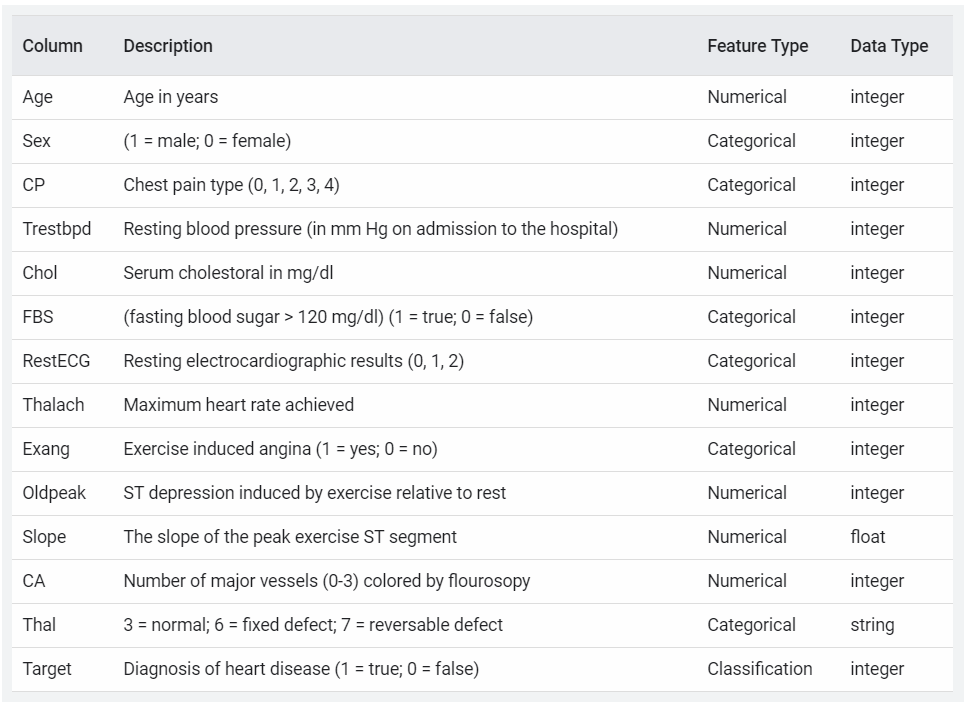

In [63]:
# import stuff
import pandas as pd
from sklearn.model_selection import train_test_split

Let's load some data.

In [ ]:
# read csv into pandas
dataframe = pd.read_csv('heart.csv')
print('dataframe.shape = {}'.format(dataframe.shape))
dataframe.head(10)

Some data preprocessing - feel free to explore further yourself

In [ ]:
# Summary Statistics
print("\nSummary Statistics:")
dataframe.describe(include='all')

In [ ]:
# categorical data
onehot_cols = ['cp', 'restecg', 'thal']
dataframe = pd.get_dummies(dataframe, columns=onehot_cols, dtype=float)
dataframe.head(5)

# Model development

Note that the outcome is imbalanced. 27.4% of the samples have heart disease.

In [ ]:
# split the dataframe into train, test
train, test = train_test_split(dataframe, test_size=0.2, random_state=42, stratify=dataframe['target'])
print(len(train), 'train examples')
print(len(test), 'test examples')

Let's develop a baseline model using logistic regression

First, let's develop the model without rescaling the data.

In [68]:
train_features = train.drop('target', axis=1).to_numpy()
train_labels = train['target'].to_numpy()
test_features = test.drop('target', axis=1).to_numpy()
test_labels = test['target'].to_numpy()

In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(random_state=42).fit(train_features, train_labels)
pred = model.predict(test_features)

print('Accuracy =', accuracy_score(test_labels, pred))

You may see a warning: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

This is because without rescaling the predictors, it is hard for the model to be trained

In [ ]:
# Predict probabilities and calculate AUC

from sklearn.metrics import roc_auc_score

pred_proba = model.predict_proba(test_features)[:, 1]
auc_score = roc_auc_score(test_labels, pred_proba)

auc_score

Let's rescale the data this time.

In [71]:
# standardisation
from sklearn.preprocessing import StandardScaler

train_features = train.drop('target', axis=1).to_numpy()
train_labels = train['target'].to_numpy()
test_features = test.drop('target', axis=1).to_numpy()
test_labels = test['target'].to_numpy()

scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

Think about why we "fit" train_features only, and use the statistics of train_features to "transform" test features. \
Hint: Google data leakage or visit https://machinelearningmastery.com/data-preparation-without-data-leakage/

In [ ]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(random_state=42).fit(train_features, train_labels)
pred = model.predict(test_features)

print('Accuracy =', accuracy_score(test_labels, pred))

In [ ]:
# Predict probabilities and calculate AUC

from sklearn.metrics import roc_auc_score

pred_proba = model.predict_proba(test_features)[:, 1]
auc_score = roc_auc_score(test_labels, pred_proba)

auc_score

Now you can see the model can converge

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute the ROC curve
fpr, tpr, _ = roc_curve(test_labels, pred_proba)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'(AUC = {auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Let's try random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=10)
rf_model.fit(train_features, train_labels)

# Predict probabilities and calculate AUC
rf_test_pred_proba = rf_model.predict_proba(test_features)[:, 1]
rf_auc_score = roc_auc_score(test_labels, rf_test_pred_proba)

rf_auc_score

You may notice that the performance is worse than that of logistic regression. This is because the more complex a model is, the harder it is to train. Now, let's try to improve the model.

Let's do some hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'bootstrap': [True, False]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(train_features, train_labels)

# Get best parameters and best model
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict probabilities and calculate AUC using best model
best_rf_test_pred_proba = best_rf_model.predict_proba(test_features)[:, 1]
best_rf_auc_score = roc_auc_score(test_labels, best_rf_test_pred_proba)

best_params, best_rf_auc_score

You can see the performance of the model increased slightly. Note, we are using AUROC to track the performance of the model with different hyper parameter combos.

# Practice

1. Try to develop some other models using sklearn and do some hyper parameter tuning.

2. Try to develop an XGBoost model and tune the hyper parameters. You may need to use "pip install xgboost"\
   Hint: use "from xgboost import XGBClassifier" to load the model

3. Try to develop a regression model to predict resting blood pressure "trestbps".\
   Hint: You will need other evaluation metrics to track the performance of the model with different hyper parameter combos.